# DCGAN on Bricks Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb)
- Dataset: [Kaggle](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images)

In [1]:
import os
from collections import defaultdict
from PIL import Image
from IPython import display
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary
from torcheval import metrics as Metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 300
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1),
                            Transforms.Normalize((0.5), (0.5))])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    print('Train data size: ', len(lego_dataset))
    print('Num. train batchs: ', len(train_loader))
    return train_loader

In [5]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

# plot training records
def show_records(history):
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

Train data size:  40000
Num. train batchs:  313
torch.Size([128, 1, 64, 64])


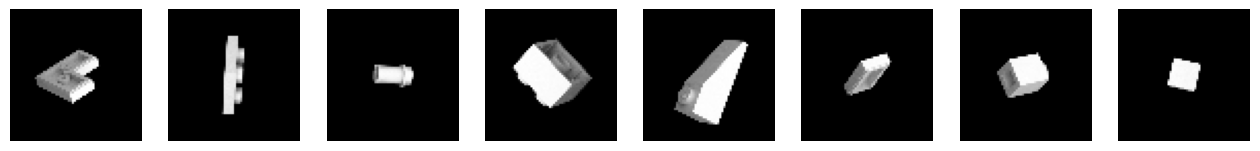

In [6]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)

# test = Discriminator().to(DEVICE)
# summary(test, (1, 64, 64))

In [8]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x

    
    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

# generator = Generator(Z_DIM).to(DEVICE)
# summary(generator, (100,))

In [9]:
class DCGAN(nn.Module):
    
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()


    def forward(self, real_imgs):
        latents = torch.randn(size=(len(real_imgs), self.z_dim)).to(DEVICE)
        generated_imgs = self.generator(latents)

        real_preds = self.discriminator(real_imgs)
        fake_preds = self.discriminator(generated_imgs)
        
        return real_preds, fake_preds, generated_imgs

dcgan = DCGAN(Z_DIM).to(DEVICE)
summary(dcgan, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

## 3. Define the model, objective, and optimizer

In [10]:
dcgan = DCGAN(Z_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    dcgan = torch.compile(dcgan, backend='eager')
    print('model compiled')

loss_fn = nn.BCELoss()
d_optim = torch.optim.Adam(params=dcgan.discriminator.parameters(), lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=dcgan.generator.parameters() ,lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))

train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
    'd_real_acc': Metrics.BinaryAccuracy(),
    'd_fake_acc': Metrics.BinaryAccuracy(),
    'g_acc': Metrics.BinaryAccuracy(),
}

model compiled


## 4. Get dataloader

In [11]:
lego_dataloader = get_dataloader()

Train data size:  40000
Num. train batchs:  313


## 5. Train step function

In [12]:
def train(model, dataloader, d_optim, g_optim, loss_fn, train_metrics):
    
    model.train() # Set model to train mode
    
    for metric in train_metrics.values():
        metric.reset() # clear metrics data

    for i, train_imgs in enumerate(dataloader):

        # 1. Update Discriminator
        model.discriminator.zero_grad()

        train_imgs = train_imgs.to(DEVICE)
        real_preds, fake_preds, generated_imgs = model(train_imgs)

        # get loss with the real dataset
        real_labels = torch.ones_like(real_preds, dtype=torch.float)
        real_noisy_labels = real_labels + NOISE_PARAM * torch.randn(size=real_labels.shape, device=DEVICE)
        d_real_loss = loss_fn(real_preds.reshape(-1), real_noisy_labels.reshape(-1))
        d_real_loss.backward(retain_graph=True)

        # get loss with the generated dataset
        fake_labels = torch.zeros_like(fake_preds, dtype=torch.float)
        fake_noisy_labels = fake_labels - NOISE_PARAM * torch.randn(size=fake_labels.shape, device=DEVICE)
        d_fake_loss = loss_fn(fake_preds.reshape(-1), fake_noisy_labels.reshape(-1))
        d_fake_loss.backward(retain_graph=True)

        d_loss = d_fake_loss + d_real_loss # for metrics purpose, not training
        d_optim.step()

        # 2. Update Generator
        model.generator.zero_grad()
        g_loss = loss_fn(fake_preds.reshape(-1), real_labels.reshape(-1))

        g_loss.backward()
        g_optim.step()
    
        # Update metrics
        train_metrics['d_loss'].update(d_loss.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['d_fake_acc'].update(fake_preds.reshape(-1).detach().cpu(), fake_labels.reshape(-1).detach().cpu())
        train_metrics['d_real_acc'].update(real_preds.reshape(-1).detach().cpu(), real_labels.reshape(-1).detach().cpu())
        train_metrics['g_acc'].update(fake_preds.reshape(-1).detach().cpu(), real_labels.reshape(-1).detach().cpu())

        del d_loss, g_loss, fake_preds, real_preds, real_labels, real_noisy_labels, fake_labels, fake_noisy_labels

    return generated_imgs

## 6. Train DCGAN

Epoch: 300	epoch time 0.37 min
	 d_loss: 0.1432 | g_loss: 6.3277 | d_real_acc: 0.9749 | d_fake_acc: 0.9733 | g_acc: 0.0267 | 


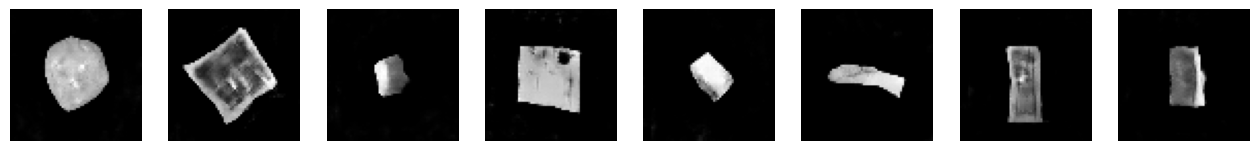

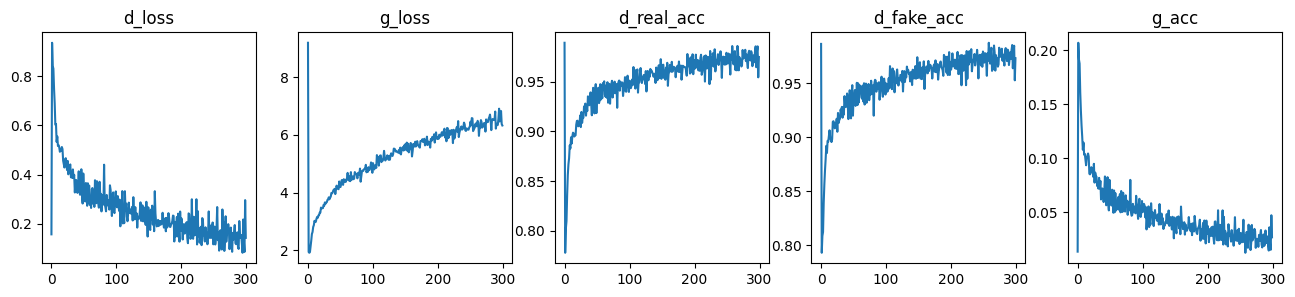

In [13]:
history = defaultdict(list)

for i in range(EPOCHS):
    prev_time = time.time()
    generated_imgs = train(dcgan, lego_dataloader, d_optim, g_optim, loss_fn, train_metrics)
    curr_time = time.time()
    
    for key, value in train_metrics.items():
        history[key].append(value.compute().item())

    display.clear_output(wait=True)

    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item():.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))
    
    generated_imgs = generated_imgs.detach().cpu()
    display_imgs(generated_imgs)
    show_records(history)

In [15]:
torch.save(dcgan.state_dict(), './models/dcgan.pt')

## 7. Generate new images

In [26]:
# sample lantent vector from normal distribution
grid_width, grid_height = (10, 3)
z_samples = torch.randn(size=(grid_width * grid_height, Z_DIM), device=DEVICE)
generated_imgs = dcgan.generator(z_samples)

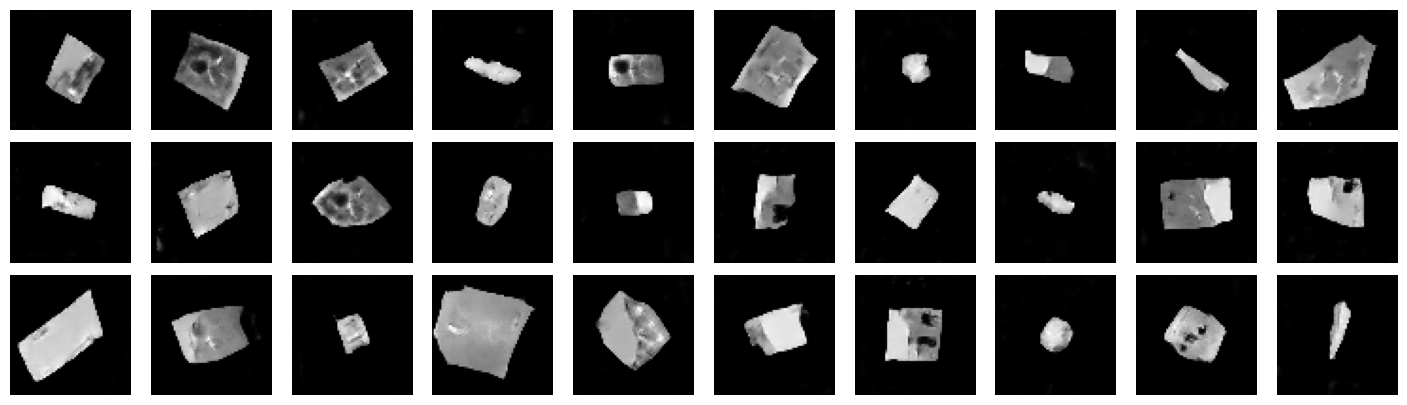

In [27]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i][0].detach().cpu(), cmap="gray")

## 8. Output matching

In [47]:
total_imgs = None
for i, sample_batch in enumerate(lego_dataloader):
    if i == 0:
        total_imgs = sample_batch
    else:
        total_imgs = torch.cat([total_imgs, sample_batch], dim=0)
print(total_imgs.shape)

torch.Size([40000, 1, 64, 64])


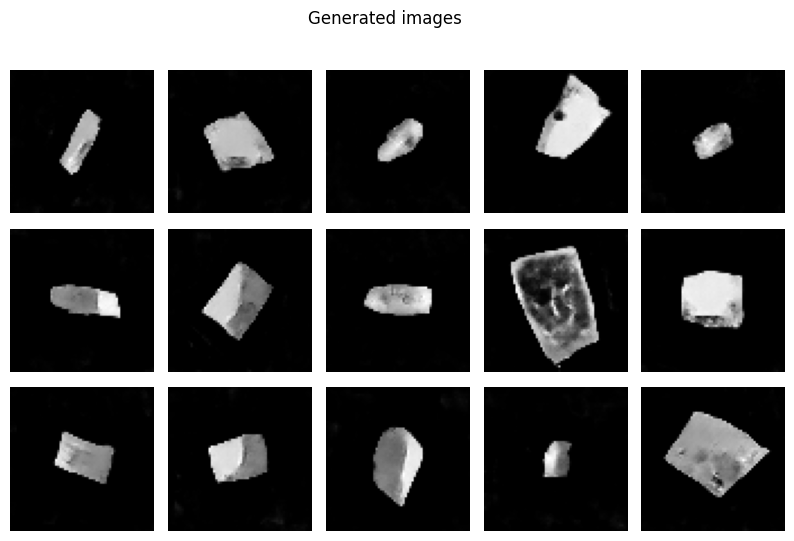

In [48]:
grid_width, grid_height = (5, 3)
z_samples = torch.randn(size=(grid_width * grid_height, Z_DIM), device=DEVICE)
dcgan.eval()
with torch.no_grad():
    generated_imgs = dcgan.generator(z_samples).detach().cpu()

# Draw a plot of decoded images
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Generated images')

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i][0], cmap="gray")

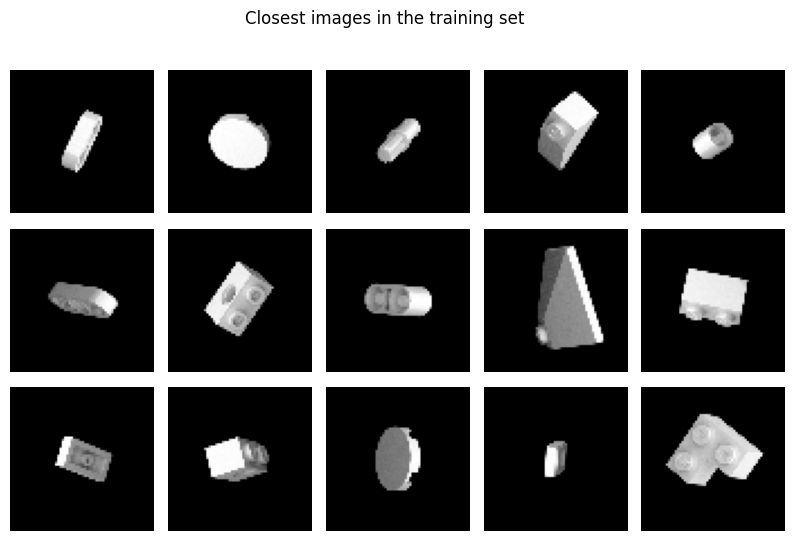

In [49]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle('Closest images in the training set')

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    # Compare images
    gen_img = generated_imgs[i].unsqueeze(0)
    L1_dist = (total_imgs - gen_img).abs().reshape(total_imgs.shape[0], -1).mean(dim=1)
    selection = L1_dist.argmin().item()
    
    ax.imshow(total_imgs[selection][0], cmap="gray")